# 一、脑电信号的非线性动力学分析方法


In [1]:
import numpy as np
import pyeeg
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import pywt
%matplotlib inline

In [5]:
channel = [0,2,3,16,18,19,20] # FP1,F3,F7,FP2,FZ,F4,F8
channel_names = ['FP1','F3','F7','FP2','FZ','F4','F8']
band = [4,8,14,30,45] # 4 bands
sample_rate = 128 # Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16',
               '17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']

iter_freqs = [
#     {'name': 'Delta', 'fmin': 0, 'fmax': 4},
    {'name': 'Theta', 'fmin': 4, 'fmax': 8},
    {'name': 'Alpha', 'fmin': 8, 'fmax': 14},
    {'name': 'Beta', 'fmin': 14, 'fmax': 30},
    {'name': 'Gamma', 'fmin': 30, 'fmax': 45},
]

## 1、近似熵
* 设原始信号为{x(i),i=1,2,...,N}，按照下面公式重构出 m 维向量，用 y（i）表示，{ y(i),i=1,2,...,M,M=N-m+1},即：
    $$y(i)=\{x(i),x(i+1),x(i+2), ,x(i+m-1)\}$$
  其中，m 是嵌入维数，是参与比较序列的长度，即窗口长度。
* 计算 y(i)与 y(j)任意分量之间的欧式距离 d\{y(i),y(j)\}，并将各个分量之间最大的距离定义为最大贡献成分距离 D\{y(i),y(j)\}，如下式所示：
    $$D\{y(i),y(j)\}=max\{|y(i+k)-y(j+k)|\}$$
   其中，i，j = 1,2, ,N-m+1， k=0,1,...,m-1。
* 给定阈值 r（r>0），给定嵌入维数 m，计算代表序列{y(i)}规律性的概率大小量度$C_i^m(r)$，即统计 D{y(i),y(j)}<r <font color='red'>（包括i=j）</font>的个数$N^m(i)$与总数 N-m+1 的比例，也即概率大小，如公式所示：
    $$C_i^m(r)$ = $N^m(i) / (N-m+1)$$
   其中， i<=N-m+1。
* 对每个求得的$C_i^m(r)$，计算其对数值，并求对数的平均值，如公式所示：
    $$\phi^m(i) = (\displaystyle \sum^{N-M+1}_{i=1}{lnC_i^m(r)})/(N-m+1)$$
* 将嵌入维数变为 m+1，重复步骤（1）到（4），得到$C_i^m(r)$ 和$\phi^{m+1}(i)$。所以该序列的近似熵可以表示为如下公式：
    $$ApEn(m,r) = \phi^m(i) - \phi^{m+1}(i)$$

注：选取嵌入维数 m=2，有效阈值 r=0.15*std

In [6]:
def maxdist(x_i, x_j):
    """计算矢量之间的距离"""
    return np.max([np.abs(np.array(x_i) - np.array(x_j))])

def _std(data):
    """计算标准差"""
    if not isinstance(data, np.ndarray):
            data = np.array(data)
    return np.std(data)

def _normalization(data):
    """将数据标准化，所有值减去平均值除以标准差"""
    _mean = np.mean(data)
    data_std = _std(data)
    return np.array([(x - _mean) / data_std for x in data])

def phi(x, m, r):
    """计算熵值"""
    length = len(x)-m+1
    # 重构m维向量
    y = [x[i:i+m] for i in range(length)]
     
    # 获取所有的比值列表
    C = [ len([1 for y_j in y if maxdist(y_i, y_j) < r]) / length for y_i in y ]
    
    for i in range(length):
        C[i] = np.log(C[i])
    return np.mean(np.sum(C))

def Approximate_Entropy(data, m):
    """计算近似熵"""
    x = data
    data_std = _std(x)
    r = data_std * 0.15
    return phi(x,m,r) - phi(x,m+1,r)

In [57]:
# 使用自定义函数计算近似熵
def solve_1():
    calm = []
    stress = []
    print("calm:")
    for i in range(7):
        with open('F:\EEG\paper1\calm\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[1][0][0:1000]
            ep = Approximate_Entropy(data, 2)
            calm.append(ep)
            print(ep)
    print("stress:")
    for i in range(7):
        with open('F:\EEG\paper1\stress\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[0][0][0:1000]
            ep = Approximate_Entropy(data, 2)
            stress.append(ep)
            print(ep)
            
    return calm,stress

In [58]:
calm, stress = solve_1()

calm:
1425.3170864764807
1401.6615184932216
1395.2724768377348
1417.7058465622313
1350.4724876568198
1401.5277319906618
1448.6775416933779
stress:
1347.4378531706188
1354.253081933508
1321.9189806589766
1359.2610588638972
1298.6386500286408
1353.7816421752368
1365.3502337475138


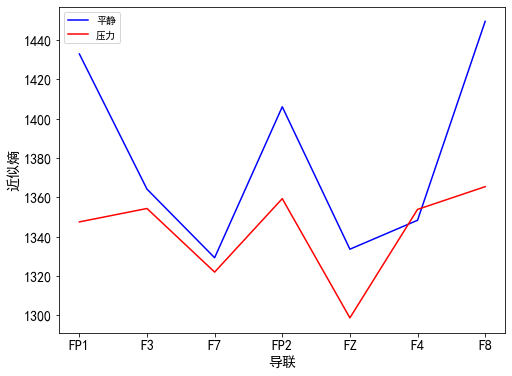

In [48]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm  # sub[0]
z = stress
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()

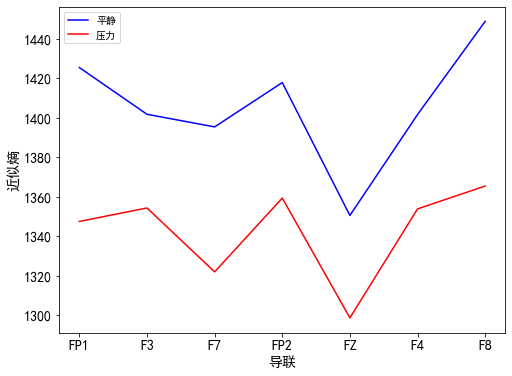

In [59]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm  # sub[1]
z = stress
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()

In [5]:
# 用pyeeg模块计算近似熵
def solve_1_1():
    calm = []
    stress = []
    print("calm:")
    for i in range(7):
        with open('F:\EEG\paper1\calm\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[1][0][0:1000]
            r = np.std(data) * 0.15
            ep = pyeeg.ap_entropy(data, 2, r)
            calm.append(ep)
            print(ep)
    print("stress:")
    for i in range(7):
        with open('F:\EEG\paper1\stress\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[0][0][0:1000]
            r = np.std(data) * 0.15
            ep = pyeeg.ap_entropy(data, 2, r)
            stress.append(ep)
            print(ep)
            
    return calm,stress

In [71]:
calm_2, stress_2 = solve_1_1()

calm:
0.4979281282242622
0.443695277918513
0.442472263494819
0.43854070702659526
0.4157744994967284
0.43669639312739156
0.4577720510543133
stress:
0.41374190695563756
0.4308971911682593
0.39423375782158454
0.39676674907047593
0.3751900916203876
0.3924114337549988
0.40667143219963087


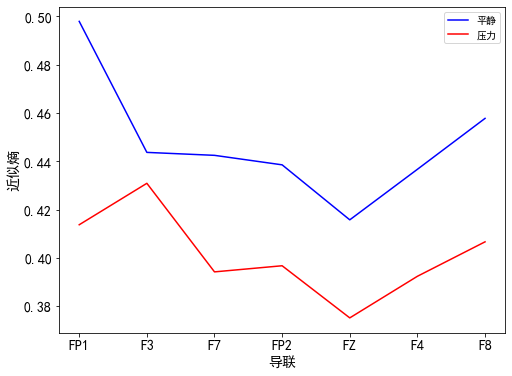

In [72]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm_2  # sub[1]
z = stress_2
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()

## 2、样本熵
* 设原始信号为{x(i),i=1,2,...,N}，按照下面公式重构出 m 维向量，用 y（i）表示，{ y(i),i=1,2,...,M,M=N-m+1},即：
    $$y(i)=\{x(i),x(i+1),x(i+2), ,x(i+m-1)\}$$
  其中， m 是选定的空间维度矢量，也即窗口长度，表示从第 i 个点开始的连续 m 个值。
* 计算 y(i)与 y(j)任意分量之间的欧式距离 d{y(i),y(j)}，并将各个分量之间最大的距离定义为最大贡献成分距离 D{y(i),y(j)}，如下式所示：
    $$D\{y(i),y(j)\}=max\{|y(i+k)-y(j+k)|\}$$
   其中，i，j = 1,2, ,N-m+1， k=0,1,...,m-1。
* 给定阈值 r（r>0），给定嵌入维数 m，计算代表序列{y(i)}规律性的概率大小量度$C_i^m(r)$，即统计 D{y(i),y(j)}<r <font color='red'>（$i\neq j$）</font>的个数$N^m(i)$与总数 N-m+1 的比例，也即概率大小，如公式所示：
    $$C_i^m(r) = N^m(i) / (N-m+1)$$
   其中， i<=N-m。$N^m(i)$也叫做模板匹配数，其中 i<=N-m。并且对所有的$C_i^m(r)$求平均值：
    $$B^m(r) = {1 \over {N-m}} (\displaystyle \sum^{N-m}_{i=1} C_i^m(r))$$
* 将嵌入维数设为 m+1，重复步骤（1）到（3），同理得到$B^{m+1}(r)$。所以可以得到该序列的样本熵为:
    $$SampEn(m,r) = \displaystyle \lim_{N \rightarrow \infty}[-ln{{B^{m+1}(r)} \over {B^m(r)}]}$$
   若 N 为有限值时，样本熵可为：
    $$SampEn(m,r) = -ln{{B^{m+1}(r)} \over {B^m(r)}}$$
    
注：一般选取嵌入维数 m=2，有效阈值 r一般选 0.1~0.25 倍的原始数据标准差

In [20]:
def maxdist(x_i, x_j):
    """计算矢量之间的距离"""
    return np.max([np.abs(np.array(x_i) - np.array(x_j))])

def _std(data):
    """计算标准差"""
    if not isinstance(data, np.ndarray):
            data = np.array(data)
    return np.std(data)

def phi_2(x, m, r):
    """计算熵值"""
    length = len(x) - m + 1
    # 重构m维向量
    y = [x[i:i+m] for i in range(length)]
     
    # 获取所有的比值列表(不与自身匹配。不包括最后一个向量,注意是N-m不是N-m+1)
    C = [ len([1 for y_j in y[:-1] if maxdist(y_i, y_j) < r and (y_i != y_j).any()]) / (length-1) for y_i in y[:-1] ]
    
    ans = 0
    for i in range(length - 1):
        ans += C[i]
    return ans / (length - 1)

def Sample_Entropy(data, m):
    """计算样本熵"""
    x = data
    data_std = _std(x)
    r = data_std * 0.15
    return - np.log(phi_2(x,m+1,r) / phi_2(x,m,r))

In [21]:
# 使用自定义函数计算样本熵
def solve_2():
    calm = []
    stress = []
    print("calm:")
    for i in range(7):
        with open('F:\EEG\paper1\calm\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[1][0][0:1000]
            ep = Sample_Entropy(data, 2)
            calm.append(ep)
            print(ep)
    print("stress:")
    for i in range(7):
        with open('F:\EEG\paper1\stress\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[0][0][0:1000]
            ep = Sample_Entropy(data, 2)
            stress.append(ep)
            print(ep)
            
    return calm,stress

In [22]:
calm_3, stress_3 = solve_2()

calm:
1.976000317365259
1.8803323323384515
1.8519820709406967
1.8762792685733864
1.7246242944155168
1.8310340122558515
1.942707292331822
stress:
1.7355979423688612
1.7832749522178173
1.6285091486614167
1.6794526090131472
1.5912014362417153
1.6838467628474498
1.7466101651273773


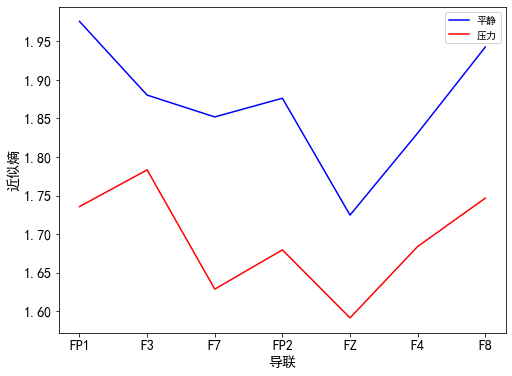

In [23]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm_3  # sub[1]
z = stress_3
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()

In [14]:
# 用pyeeg模块计算样本熵
def solve_2_2():
    calm = []
    stress = []
    print("calm:")
    for i in range(7):
        with open('F:\EEG\paper1\calm\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[1][0][0:1000]
            r = np.std(data) * 0.15
            ep = pyeeg.samp_entropy(data, 2, r)
            calm.append(ep)
            print(ep)
    print("stress:")
    for i in range(7):
        with open('F:\EEG\paper1\stress\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[0][0][0:1000]
            r = np.std(data) * 0.15
            ep = pyeeg.samp_entropy(data, 2, r)
            stress.append(ep)
            print(ep)
            
    return calm,stress

In [15]:
calm_4, stress_4 = solve_2_2()

calm:
1.9762284404769834
1.8826001222483795
1.8517628352002349
1.8788210457608794
1.7242157024144538
1.833906300050725
1.9449120453692992
stress:
1.7366936387945835
1.785641040927491
1.6306346525115132
1.682317245250243
1.5932305842091745
1.6868171818968165
1.750320956296668


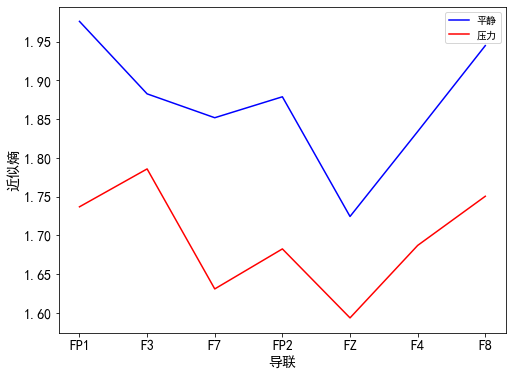

In [16]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm_4  # sub[1]
z = stress_4
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()

## 3、排列熵
* 设信号时间序列为{X(i),i=1,2,...,n}，进行相空间重构后，得到如下矩阵：
$$\left[ \begin{matrix} x(1) & x(1+\tau) & \cdots & x(1+(m-1)\tau)\\ x(2) & x(2+\tau) & \cdots & x(2+(m-1)\tau) \\ \vdots & \vdots & \ddots & \vdots \\ x(k) & x(k+\tau) & \cdots & x(k+(m-1)\tau) \end{matrix} \right]$$
    其中，m是嵌入维数，$\tau$是延时因子，$k=n-(m-1)\tau$，j=1,2,...,k。矩阵共有 k 个重构分量，每个重构分量有 m 维嵌入元素。
* 将矩阵中的第j个分量$x(j),x(j+\tau),\cdots,x(j+(m-1)\tau)$按照数值的大小进行升序排列，得到：
$$x(i+(j_1-1)\tau) \leq x(i+(j_2-1)\tau) \leq \cdots x(i+(j_m-1)\tau)$$
    其中$j_1,j_2,\cdots,j_m$代表各元素在重构分量中的下标索引值。如果在重构分量中有两个或多个相等的值，比如$x(i+(j_1-1)\tau)=x(i+(j_2-1)\tau)$时，则需要根据$j_1、j_2$的大小来进行排序。满足$j_1<j_2$即可，此时有：$x(i+(j_1-1)\tau) \leq x(i+(j_2-1)\tau)$
* 每个重构分量都可以得到一个重构符号序列:
$$S(l)=(j_1,j_2,\cdots.j_m)$$
    其中,l=1.2.$\cdots$,k，满足$k \leq m!$ 。每个重构分量是 m 维空间，映射到 m 维符号序列，共有 m!种排列方式。
* 计算每一种m维符号序列的概率$P_1,P_2,\cdots,P_K$，那么，根据香浓熵的定义，信号时间序列 X(i)的排列熵（PE）定义为:
$$H_p(m) = -(\displaystyle \sum^k_{j=1}P_jlnP_j)$$
    其中，当$P_j=1/m!$时，排列熵达到最大值ln(m!)。实际的处理过程中，通常将$H_p(m)$进行归一化的处理：
$$0 \leq H_p=H_p/ln(m!)\leq1$$

In [40]:
def func(n):
    """求阶乘"""
    if n == 0 or n == 1:
        return 1
    else:
        return (n * func(n - 1))

def compute_p(S):
    """计算每一种 m 维符号序列的概率"""
    _map = {}
    for item in S:
        a = str(item)
        if a in _map.keys():
            _map[a] = _map[a] + 1
        else:
            _map[a] = 1
            
    freq_list = []
    for freq in _map.values():
        freq_list.append(freq / len(S))
    return freq_list

def Permutation_Entropy(x, m, t):
    """计算排列熵值"""
    length = len(x) - (m-1) * t
    # 重构 k*m 矩阵
    y = [x[i:i+m*t:t] for i in range(length)]
    
    # 将各个分量升序排序
    S = [np.argsort(y[i]) for i in range(length)]
    
    # 计算每一种 m 维符号序列的概率
    freq_list = compute_p(S)
    
    # 计算排列熵
    pe = 0
    for freq in freq_list:
        pe += (- freq * np.log(freq))
    
    return pe / np.log(func(m))

In [53]:
# 自定义函数计算排列熵
def solve_3():
    calm = []
    stress = []
    print("calm:")
    for i in range(7):
        with open('F:\EEG\paper1\calm\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[1][0][0:1000]
            ep = Permutation_Entropy(data, 5, 10)
            calm.append(ep)
            print(ep)
    print("stress:")
    for i in range(7):
        with open('F:\EEG\paper1\stress\s01\_' + channel_names[i] + '.npy', 'rb') as file:
            sub = np.load(file, encoding='latin1', allow_pickle=True)
            data = sub[2][0][0:1000]
            ep = Permutation_Entropy(data, 5, 10)
            stress.append(ep)
            print(ep)
            
    return calm,stress

In [51]:
calm_5, stress_5 = solve_3()

calm:
0.981523229008103
0.9864536730866214
0.9833505287558257
0.9875743887952972
0.9839812201187867
0.9809881951855935
0.9840484765461492
stress:
0.9799296559349688
0.9833267617472861
0.982422573986235
0.9845848402709394
0.9775282762031882
0.9754061208625978
0.9808584016704598


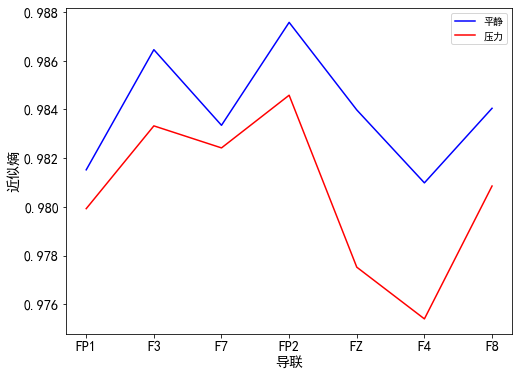

In [52]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

y = calm_5  # sub[1]
z = stress_5  # sub[2]
fig = plt.figure(figsize=(8, 6))

labels = ['FP1', 'F3', 'F7', 'FP2', 'FZ', 'F4', 'F8']

plt.xlabel("导联", fontsize=14)
plt.ylabel("近似熵", fontsize=14)

plt.plot(labels, y, c='b', label="平静")
plt.plot(labels, z, c='r', label="压力")
plt.tick_params(axis='both', labelsize=14)
plt.legend()
plt.show()